# 分子修改与编辑

# 一、初级篇

## 1.氢原子显示与隐藏
正常情况下，分子在rdkit中存储时，氢以隐式氢的形式存储，即不会在图片中显示出来。当需要加入氢原子时，例如要生成和优化立体结构，可以通过函数加上氢原子。
- 加氢：AddHs()
- 去氢：RemoveHs()

In [1]:
from rdkit import Chem
m = Chem.MolFromSmiles('CCO')
print(m.GetNumAtoms())
m2 = Chem.AddHs(m)
print(m2.GetNumAtoms())
m2 = Chem.RemoveHs(m2)
print(m2.GetNumAtoms())

3
9
3


## 2.芳香键与kekule式转换
- 芳香键在Rdkit中存储类型为"AROMATIC"，可以转化为kelule式：Kekulize()

In [2]:
m = Chem.MolFromSmiles('c1ccccc1')
print(m.GetBondWithIdx(0).GetBondType())
Chem.Kekulize(m)
print(m.GetBondWithIdx(0).GetBondType())
print(m.GetBondWithIdx(1).GetBondType())

AROMATIC
DOUBLE
SINGLE


转化后，类型中虽然变为单键和双键，但依然是芳香键
- 查看是否为芳香键：GetIsAromatic()

In [3]:
print(m.GetBondWithIdx(1).GetIsAromatic())

True


- 之所以仍然为芳香键，是因为分子有一个跟芳香性相关的属性Flags，记录了芳香性的信息。可以在kelulize时将clearAromaticFlags参数设置为True

In [4]:
Chem.Kekulize(m, clearAromaticFlags=True)
print(m.GetBondWithIdx(0).GetBondType())
print(m.GetBondWithIdx(1).GetIsAromatic())

DOUBLE
False


- 如果想修改回芳香键，可以对分子进行检查：SanitizeMol()

In [5]:
Chem.SanitizeMol(m)
print(m.GetBondWithIdx(0).GetBondType())

AROMATIC


# 二、高级篇

## 1.Atom和Bond对象的编辑功能
在rdkit的Atom对象中也提供了一系列功能，可以对分子进行原位编辑。
- 修改形式电荷：atom.SetFormalCharge(int)
- 修改杂化方式为SP3：atom.HybridizationType(Chem.HybridizationType.SP3)
- 修改为芳香原子：atom.SetIsAromatic(True)
- 修改为同位素标记原子：atom.SetIsotope(int)
- 不带隐式氢：atom.SetNoImplicit(True)
- 固定显示氢：atom.SetNumExplicitHs(int)

Bond对象类似

- 修改键的显示方式：SetBondDir(Chem.BondDir.BEGINDASH)
- 修改为芳香键：SetBondType(Chem.BondType.AROMATIC)
- 修改键芳香性的Flags：SetIsAromatic(bool)
- 是否共轭：SetIsConjugated(bool)

不一一说明了，感兴趣可以试试各个函数及相关参数，举几个可能会遇到的例子
- 修改手性碳：SetChiralTag()<br />
参数设置为Chem.ChiralType.CHI_TETRAHEDRAL_CCW时，为S型（Counter Clockwise，逆时针）<br />
参数设置为Chem.ChiralType.CHI_TETRAHEDRAL_CW时，为R型（Clockwise，顺时针）<br />
还有CHI_OTHER、CHI_UNSPECIFIED不指定类型

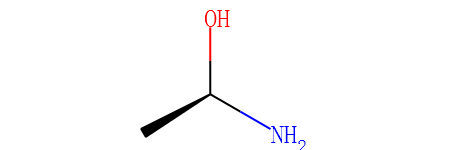

In [6]:
m = Chem.MolFromSmiles('OC(N)C')
m.GetAtomWithIdx(1).SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)
m

In [7]:
Chem.Draw.MolToFile(m, 'data/modifying_mols_0.png', size=(250, 250))

- 修改原子：atom.SetAtomicNum()

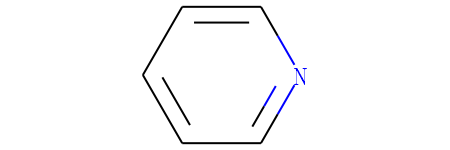

In [8]:
m = Chem.MolFromSmiles('c1ccccc1')
m.GetAtomWithIdx(0).SetAtomicNum(7)
Chem.SanitizeMol(m)
Chem.MolToSmiles(m)
m

- 别忘了检查步骤，虽然有时候看起来没什么问题

In [9]:
m = Chem.MolFromSmiles('c1ccccc1')
m.GetAtomWithIdx(0).SetAtomicNum(8)
Chem.MolToSmiles(m)

'c1ccocc1'

- 但该分子本身其实是错误的：SanitizeMol()

In [10]:
Chem.SanitizeMol(m)

KekulizeException: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5


## 2.RWMol的编辑功能
更复杂的操作可以使用rdkit.Chem.rdchem.RWMol类（用于分子读写的类）。这个类在修改分子方面，性能更好，它可以提供一个“活动的”分子，并且共享了mol对象的操作接口。修改完毕后，只需要用GetMol()就可以获得最终的分子

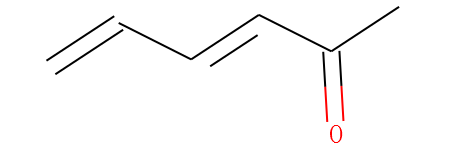

In [11]:
m = Chem.MolFromSmiles('CC(=O)C=CC=C')
mw = Chem.RWMol(m)
mw

In [12]:
Chem.Draw.MolToFile(mw, 'data/modifying_mols_1.png', size=(250, 250))

- 替换原子：ReplaceAtom(index, newAtom, updateLabel, preserveProps)<br />
index：要替换的原子索引<br />
newAtom：新的原子对象

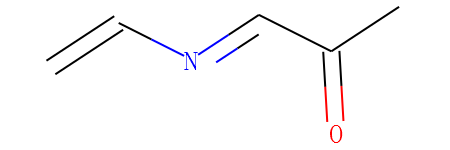

In [13]:
mw.ReplaceAtom(4, Chem.Atom(7))
mw

In [14]:
Chem.Draw.MolToFile(mw, 'data/modifying_mols_2.png', size=(250, 250))

- 添加原子：AddAtom(atom)<br />
atom：要添加的原子对象<br />
返回值是新添加原子的索引

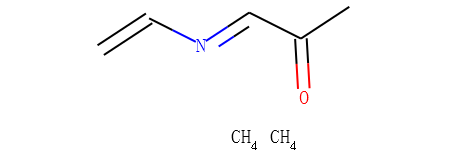

In [15]:
mw.AddAtom(Chem.Atom(6))
mw.AddAtom(Chem.Atom(6))
mw

In [16]:
Chem.Draw.MolToFile(mw, 'data/modifying_mols_3.png', size=(250, 250))

- 添加键：AddBond(beginAtomIdx, endAtomIdx, order)<br />
beginAtomIdx：键的起始原子<br />
endAtomIdx：键的末尾原子<br />
order：键的类型<br />

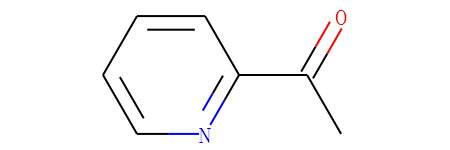

In [17]:
mw.AddBond(6, 7, Chem.BondType.SINGLE)
mw.AddBond(7, 8, Chem.BondType.DOUBLE)
mw.AddBond(8, 3, Chem.BondType.SINGLE)
mw

In [18]:
Chem.Draw.MolToFile(mw, 'data/modifying_mols_4.png', size=(250, 250))

- 删除原子：RemoveAtom()<br />
传入原子索引<br />
每次删除后，索引都会更新

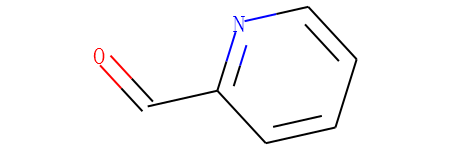

In [19]:
mw.RemoveAtom(0)
mw

In [20]:
Chem.Draw.MolToFile(mw, 'data/modifying_mols_5.png', size=(250, 250))

- 其他一些Mol的方法，对RWMol也同样适用

In [21]:
print(Chem.MolToSmiles(mw))
print(Chem.SanitizeMol(mw))
print(Chem.MolToSmiles(mw))

O=CC1=NC=CC=C1
SANITIZE_NONE
O=Cc1ccccn1


- 修改完后，可以获取该分子的Mol对象：mw.GetMol()

In [22]:
m_edit = mw.GetMol()
type(m_edit)

rdkit.Chem.rdchem.Mol